# ML004.03: Simple CNN

In this script, we build out a machine learning classifier. We use the feature extractor from the CaracalRT trial, as this is an efficient way of converting a wavefile to a small spectral image. 

This is a teeny tiny CNN - the aim is to have as few parameters as possible so that it can be efficiently executed on the microcontroller. Generally, if the number of parameters < 1k, then it should be implementable and runnable in real-time. Beyond this will require much more thinking/optimization/pain/suffering.


In [15]:
#DATASET_DIRECTORY = "C:\\CloudData\\2024\\Nepal\\N001\\Dataset"
DATASET_DIRECTORY = "C:\\Users\\Amogh\\OneDrive - University of Cambridge\\Programming-New\\CaracalChitalDetector\\andrew_cnn\\output"
output_prefix = "03MLouput20240811v001.keras"

# Parameters:

The parameters in the cell below are tagged with the label "parameters" and can be adjusted externally e.g. with a Papermill script to perform hyperparameter optimization.

In [2]:
ML_SR = 8000 # Target sampling rate
SPECD_FFT_LEN =  512 # Real FFT length (in the M4F - we use double of this on the PC as we don't do single-sided)
ML_BIN_AGG = 14 # Number of frequency bins (vertical dimension)
ML_FLO = 600 # Low freq
ML_FHI = 1400 # High freq
ML_FFT_STRIDE=1024 # Stride length in audio samples
ML_NUM_FFT_STRIDES = 12 # How many strides make up a sample
FILEPREFIX = "templateMaker003_002" # what to save the output files as
THRESHOLDED = False # Threshold the template or not

In [3]:
import librosa
import pylab
import numpy as np

## Window to spectral features

This is our simple magic function that ingests a single FFT window of data and turns it into spectral patches. We use these spectral patches as "features". Each time it is called it makes a "column" of the spectral image, with height NUMBINS.

We use a single-sided FFT as it takes up less space on the microcontroller by exploiting FFT symmetry. We simply aggregate the FFT bins together.

NB: There are numerous optimizations that could be done here:
* Use a smaller FFT (e.g. 128), run it 4x and aggregate along the temporal dimension
* Rather than computing the whole FFT and discarding most of it, compute the explicit DFT products for each filter band e.g. using something like the Goertzel algorithm
* Use a FIR/IIR filter as a bandpass filter to extract the spectral magnitude

In [4]:
def chunkToBinsFixed(chunk,fLo,fHi,numbins,sr):
    """convert a chunk (window) to spectral image.
    Provide the low and high frequencies in Hz for a spectral windowing
    numbins are the number of output bins between flo and fhi
    Provide the sample rate in Hz"""
    CMPLX_FFT_LEN = len(chunk)*2
    fS = np.fft.fft(chunk,n=CMPLX_FFT_LEN) # fft - note we double it for the cmplx fft
    fRes = sr/(CMPLX_FFT_LEN)   # frequency per cmplx bin
    # Find the bin indices - map from frequency to FFT index
    binLo = int(fLo/sr*CMPLX_FFT_LEN)
    binHi = int(fHi/sr*CMPLX_FFT_LEN)
    specSize = int((binHi-binLo)/numbins)
    binTotals = np.zeros(numbins)
    for k in range(numbins):
        dbSum = 0
        for j in range(specSize):
            idx = binLo + (k * specSize) + j # NB not numbins!
            # Convert complex magnitude to absolute value
            absVal = np.abs(fS[idx])
            # We add an offset so we don't take log of tiny numbers. We can explore what a sensible offset is - 1.0 is probably too high.
            absVal += 1.0 
            # Convert to "power" by taking log
            dbVal = np.log(absVal) # NB natural (not log10) base!
            # Add up all the "powers" - again, this is probably not "correct", but we are just trying to work out some useful input features
            dbSum += dbVal
        binTotals[k] = dbSum
    return binTotals


# Step 1: Example

We load and plot a random sample.

## Wavefile to spectral image

This ingests a wavefile and outputs a spectral image of the correct dimensions (ML_BIN_AGG x ML_NUM_FFT_STRIDES). Because we use a sliding window on the Caracal, we start computing this spectral image at a random offset position. 

We optionally:
- Threshold the input spectral bins to ensure they are strictly positive (which they normally are)
- Scale (normalize) each spectral image to lie between [0,1]. This per-frame normalization helps to deal with the wide dynamic range encountered in the field.

Improvements:
- Rather than just using each sample once with a random offset, we could repeatedly call this function for each sample N times, building an augmented dataset

In [5]:
def wavFileToSpecImg(fullfilename,num_strides,target_sr=8000,random_offset=4000,THRESHOLDED=True,SCALED=True):
    aud,sr = librosa.load(fullfilename,sr=target_sr)
    tList = []
    startIdx = int(np.random.uniform(random_offset))
    for idx in range(0,num_strides*ML_FFT_STRIDE,int(ML_FFT_STRIDE)):
        clip = aud[idx+startIdx:idx+startIdx+SPECD_FFT_LEN]
        q = chunkToBinsFixed(clip,ML_FLO,ML_FHI,ML_BIN_AGG,ML_SR)
        tList.append(q)
    tList = np.array(tList)
    # Thresholding
    if THRESHOLDED:
        tList = (tList >0)*tList
    if SCALED:
        # Scale the dB mag spec to +1/-1
        maxVal = np.max(tList)
        minVal = np.min(tList)
        tList = (tList-minVal)/(maxVal-minVal)
    return np.array(tList)

We can plot a 3x3 grid of randomly drawn samples from each category to show what these spectral images look like

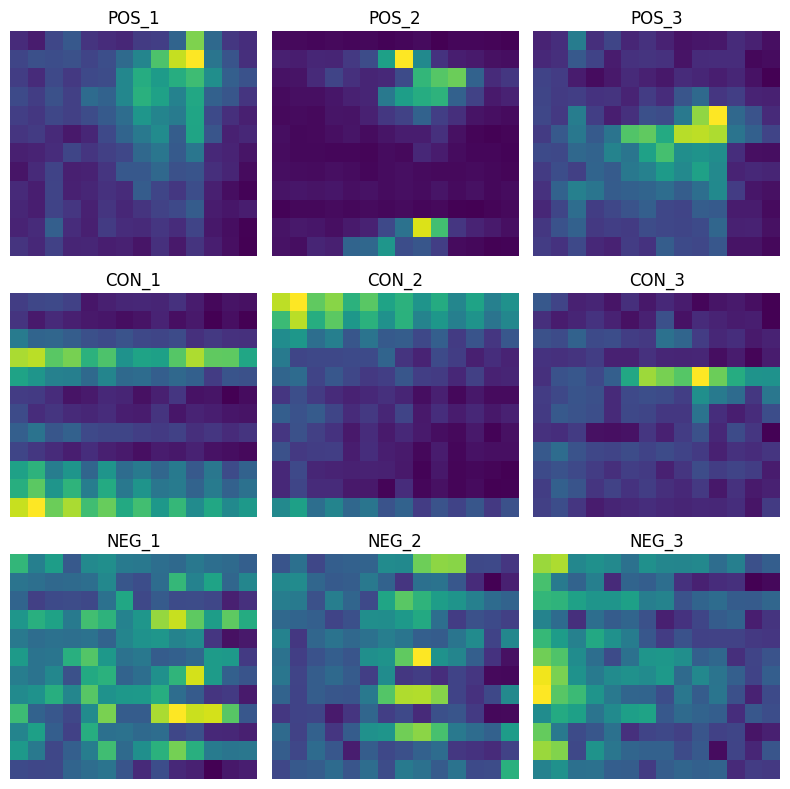

In [6]:
import random
import os

# Max sampling index
MAX_INDEX = 100

def select_random_files(prefix, max_index, num_files=3):
    indices = random.sample(range(max_index + 1), num_files)
    filenames = [f"{prefix}_{index:06d}.wav" for index in indices]
    return filenames


def create_tiled_subplots(max_index):
    prefixes = ["POS", "CON", "NEG"]
    fig, axes = pylab.subplots(3, 3, figsize=(8, 8))

    for i, prefix in enumerate(prefixes):
        filenames = select_random_files(prefix, max_index)
        full_filenames = [os.path.join(DATASET_DIRECTORY,f) for f in filenames]
        for j, filename in enumerate(full_filenames):
            image = wavFileToSpecImg(filename,num_strides=ML_NUM_FFT_STRIDES)
            ax = axes[i, j]
            ax.imshow(image, aspect='auto', cmap='viridis')
            ax.set_title(f"{prefix}_{j + 1}")
            ax.axis('off')
    
    pylab.tight_layout()
    pylab.show()

# Main code
create_tiled_subplots(MAX_INDEX)

# Main code

In [7]:
# This is a helper function to turn a given spectral image into a flattened C array. This is useful for checking that the CNN on the Caracal actually works
def specImg2C(specImg):
    flatty = specImg.flatten(order='C')
    print(f"const float32_t sample_buffer [{np.shape(flatty)[0]}]={{") 
    for k in range(len(flatty)):
        if k < (len(flatty))-1:
            print(f"{flatty[k]},")
        else:
            print(f"{flatty[k]}}};")
    

# Main machine learning loop

### Step 1: Load and convert wavefiles to spectral images

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, roc_auc_score


# Step 1: Load images and labels
def load_images_and_labels(data_dir):
    images = []
    labels = []
    for filename in os.listdir(data_dir):
        if filename.startswith("POS"):
            label = 1
        elif filename.startswith("NEG") or filename.startswith("CON"):
        #elif filename.startswith("CON"):
            label = 0
        else:
            continue
        
        file_path = os.path.join(data_dir, filename)
        clipImg = wavFileToSpecImg(file_path,num_strides=ML_NUM_FFT_STRIDES)
        images.append(clipImg)
        labels.append(label)
    
    return np.array(images), np.array(labels)

images,labels= load_images_and_labels(DATASET_DIRECTORY)


### Step 2: Reshape to the expected tensor size

In [9]:
# Step 2: Preprocess images

def preprocess_images(images):
    # Reshape to (num_samples, height, width, channels)
    return images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

images = preprocess_images(images)


### Step 3: Split to train/test 

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
#import keras
import tensorflow as tf


labels = to_categorical(labels)

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)


## Step 4: Define and train the model

We can use different metrics for optimization. Typically, we use accuracy. but it is also possible to replace with f1. This works well, but can get tricky when we save the model. We further split the train set into an 80:20 train/validation.

This cell can be easily parameterized and swept to change model properties to explore the solution space.

In [11]:

# Custom F1 score metric
#@keras.saving.register_keras_serializable()
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(K.round(y_pred), 'int32')
    TP = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    TN = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    FP = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    FN = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


# Step 4: Build the CNN followed by dense neural network
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(images.shape[1], images.shape[2], 1)))
model.add(MaxPool2D(pool_size=(4, 4))) # max pool helps to keep number of params down
model.add(Flatten())
model.add(Dense(8, activation='relu'))
#model.add(Dense(3, activation='relu')) - can easily add/drop this layer
model.add(Dense(2, activation='softmax'))

# print out the model structure/summary
model.summary()

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_metric]) # use this for f1 as loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"]) # use this for accuracy as loss
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)


C:\Users\Amogh\anaconda3\envs\internship1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 10, 12, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 3, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 490 (1.91 KB)

 Trainable params: 490 (1.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6101 - loss: 0.6704 - val_accuracy: 0.6196 - val_loss: 0.6207
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6344 - loss: 0.6079 - val_accuracy: 0.6258 - val_loss: 0.5755
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6899 - loss: 0.5409 - val_accuracy: 0.7239 - val_loss: 0.5114
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7866 - loss: 0.4752 - val_accuracy: 0.7914 - val_loss: 0.4488
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8000 - loss: 0.4360 - val_accuracy: 0.8466 - val_loss: 0.3929
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8222 - loss: 0.3752 - val_accuracy: 0.8589 - val_loss: 0.3544
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8688 - loss: 0.3185 - val_accuracy: 0.8681 - val_loss: 0.3290
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8964 - loss: 0.2870 - val_accuracy: 0.8742 - val_loss

### Step 5: Evaluate how well it works.

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


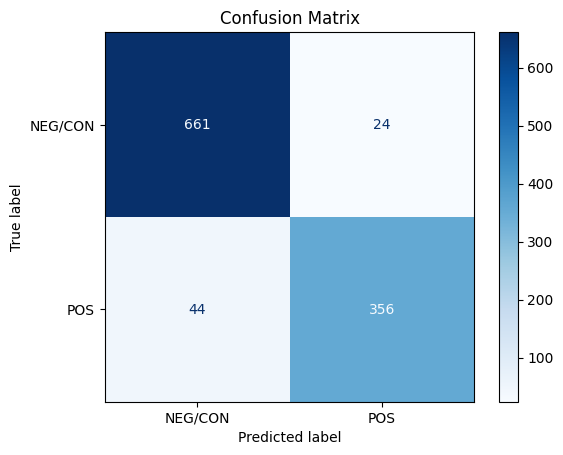

In [12]:

# Step 5: Evaluate and plot the confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG/CON", "POS"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Step 6: Show the ROC curves (TP/FP)

Here we show the ROC, as well as two arbitrary thresholds to explore the effect of thresholds on f1/accuracy. This helps the user tune if they care more about precision or sensitivity.

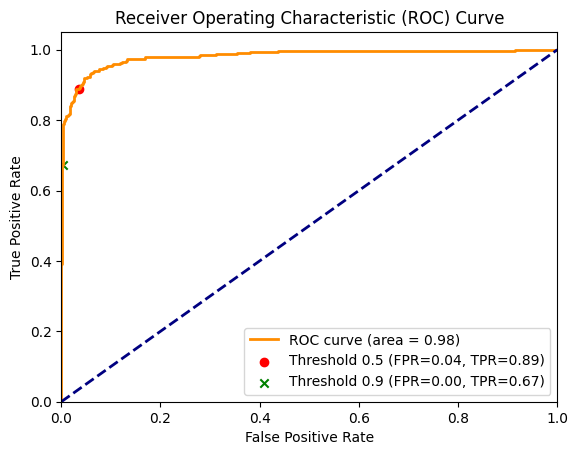

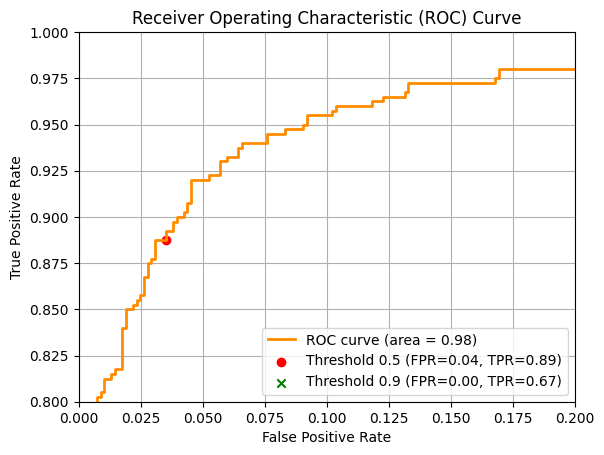

F1 Score: 0.91


In [16]:
# Step 6: Calculate and plot the ROC curve
y_prob = y_pred_prob[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test_labels, y_prob)
roc_auc = roc_auc_score(y_test_labels, y_prob)

# Find the point on the ROC curve for the threshold of 0.5
threshold = 0.5
threshold_index = np.argmin(np.abs(thresholds - threshold))
fpr_05 = fpr[threshold_index]
tpr_05 = tpr[threshold_index]


# Find the point on the ROC curve for the threshold of 0.5
threshold = 0.9
threshold_index = np.argmin(np.abs(thresholds - threshold))
fpr_09 = fpr[threshold_index]
tpr_09 = tpr[threshold_index]

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr_05, tpr_05, color='red', marker='o', label=f'Threshold 0.5 (FPR={fpr_05:.2f}, TPR={tpr_05:.2f})')
plt.scatter(fpr_09, tpr_09, color='green', marker='x', label=f'Threshold 0.9 (FPR={fpr_09:.2f}, TPR={tpr_09:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr_05, tpr_05, color='red', marker='o', label=f'Threshold 0.5 (FPR={fpr_05:.2f}, TPR={tpr_05:.2f})')
plt.scatter(fpr_09, tpr_09, color='green', marker='x', label=f'Threshold 0.9 (FPR={fpr_09:.2f}, TPR={tpr_09:.2f})')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Step 7: Calculate and print the F1 score
f1 = f1_score(y_test_labels, y_pred)
print(f"F1 Score: {f1:.2f}")

# And now we can save it (we use old-style saving)
model.save(output_prefix)
